In [1]:
import numpy as np
import torch, re, os
import tensorflow as tf
import concurrent.futures, subprocess, threading, psutil, time
import matplotlib.pyplot as plt
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

2024-02-06 12:23:51.734039: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 12:23:51.766667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 12:23:51.766691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 12:23:51.767357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 12:23:51.772032: I tensorflow/core/platform/cpu_feature_guar

## Prepare

In [3]:
# Load TensorFlow MNIST data
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize and flatten the images
train_images_tf = train_images.reshape((-1, 28*28)) / 255.0
test_images_tf = test_images.reshape((-1, 28*28)) / 255.0

# Resize for 14 * 14 images
train_images_tf_reshaped = tf.reshape(train_images_tf, [-1, 28, 28, 1])  # Reshape to [num_samples, height, width, channels]
test_images_tf_reshaped = tf.reshape(test_images_tf, [-1, 28, 28, 1])

# Downsample images
train_images_tf_downsampled = tf.image.resize(train_images_tf_reshaped, [14, 14], method='bilinear')
test_images_tf_downsampled = tf.image.resize(test_images_tf_reshaped, [14, 14], method='bilinear')

# Flatten the images back to [num_samples, 14*14]
train_images_tf_downsampled = tf.reshape(train_images_tf_downsampled, [-1, 14*14])
test_images_tf_downsampled = tf.reshape(test_images_tf_downsampled, [-1, 14*14])

2024-02-05 12:05:22.243425: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-05 12:05:22.244093: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-05 12:05:22.244153: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [16]:
def get_predictions(interpreter, test_images):
    correct_predictions = 0
    predictions = []

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    for i, img in enumerate(test_images):
        test_image = np.expand_dims(img, axis=0).astype(np.float32)
        
        # Set the value for the input tensor
        interpreter.set_tensor(input_details[0]['index'], test_image)
        
        # Run the inference
        interpreter.invoke()

        # Retrieve the output and dequantize
        output = interpreter.get_tensor(output_details[0]['index'])
        output = np.argmax(output, axis=1)
        predicted_class = output[0]

        predictions.append(predicted_class)

        if predicted_class == test_labels[i]:
            correct_predictions += 1

    # Calculate the accuracy
    accuracy = correct_predictions / len(test_images) * 100
    print(f'Quantized model accuracy: {accuracy:.2f}%')

    return predictions

In [3]:
def monitor_memory(pid, freq = 0.01):
    p = psutil.Process(pid)
    max_memory = 0
    while True:
        try:
            mem = p.memory_info().rss / (1024 * 1024)
            max_memory = max(max_memory, mem)
        except psutil.NoSuchProcess:
            break  # Process has finished
        time.sleep(freq)  # Poll every second
        
    #print(f"Maximum memory used: {max_memory} MB")
    return max_memory

def execute_and_monitor(command, show = False):
    start_time = time.time()
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(monitor_memory, process.pid)
        stdout, stderr = process.communicate()
        max_memory = future.result()
    if show:
        print(f"Maximum memory used: {max_memory} MB")
        print("Total time:", time.time() - start_time)
    return stdout, stderr, max_memory

In [4]:
def benchmark(test_images, predictions, model_in_path, test=False):
    # Convert the model
    tmp_folder = "./tmp/"
    msgpack_folder = tmp_folder + "msgpack/"
    os.makedirs(msgpack_folder, exist_ok=True)

    model_convert_path = "./tools/converter.py"
    model_out_path = tmp_folder + "msgpack/converted_model.msgpack"
    config_path = tmp_folder + "msgpack/config.msgpack"

    scale_factor = 512
    k = 17
    num_cols = 10 
    num_randoms = 1024 

    command = ["python", model_convert_path, "--model", f"{model_in_path}",
            "--model_output", f"{model_out_path}", "--config_output",
            config_path, "--scale_factor", str(scale_factor),
            "--k", str(k), "--num_cols", str(num_cols), "--num_randoms",
            str(num_randoms)]
    execute_and_monitor(command)


    loss = 0
    img_inputs_path = tmp_folder + "inputs/"
    os.makedirs(img_inputs_path, exist_ok=True)
    
    input_convert_path = "./tools/input_converter.py"
    config_out_path = msgpack_folder+"config.msgpack"

    time_circuit = "./bin/time_circuit"
    test_circuit = "./bin/test_circuit"

    call_path = time_circuit
    if test:
        call_path = test_circuit

    model_out_path = tmp_folder + "msgpack/converted_model.msgpack"

    mem_usage = []
    time_cost = []
    benchmark_start_time = time.time()

    for i, img in enumerate(test_images):
        cost = 0
        print ("Process for image", i)
        start_time = time.time()

        np.save(f"{img_inputs_path}{str(i)}.npy", img)
        
        # Convert the input to the model
        img_in_path = img_inputs_path + str(i)+ ".npy"
        img_out_path = msgpack_folder + "img_" + str(i) + ".msgpack"


        command_1 = ["python", f"{input_convert_path}", "--model_config", f"{config_out_path}",
                "--inputs", img_in_path, "--output", img_out_path]

        command_2 = [call_path, model_out_path, img_out_path, "kzg"]
        
        _, _, usage = execute_and_monitor(command_1)
        cost += usage
        stdout, _, usage = execute_and_monitor(command_2)
        cost += usage

        # Extract x values using regex
        x_values = [int(x) for x in re.findall(r'final out\[\d+\] x: (-?\d+) \(', stdout)][-10:]
        #x_values = [int(x) for x in re.findall(r'final out\[\d+\] x: (\d+)', stdout)][-10:]
        #print (x_values)

        # Find max value and its index
        max_value = max(x_values)
        max_index = x_values.index(max_value)
        
        if max_index != predictions[i]:
            loss += 1
            print ("Loss happens on index", i, "predicted_class", max_index)
        
        mem_usage.append(cost)
        time_cost.append(time.time() - start_time)

    print ("Total time:", time.time() - benchmark_start_time)
    return loss, mem_usage, time_cost

In [5]:
csv_path = '../../benchmarks/benchmark_results.csv'

columns = ['Framework', 'Architecture', '# Layers', '# Parameters', 'Testing Size', 'Accuracy Loss (%)', 
           'Avg Memory Usage (MB)', 'Std Memory Usage', 'Avg Proving Time (s)', 'Std Proving Time']

# Check if the CSV file exists
if not os.path.isfile(csv_path):
    # Create a DataFrame with the specified columns
    df = pd.DataFrame(columns=columns)
    # Save the DataFrame as a CSV file
    df.to_csv(csv_path, index=False)
else:
    print(f"File '{csv_path}' already exists.")

df = pd.read_csv(csv_path)

File '../../benchmarks/benchmark_results.csv' already exists.


# DNN

## Benchmark for 196_25_10 DNN Model
### Load and Test pretrained Model

In [10]:
model_path = "../../models/"
arch_folder = "input-dense-dense/"
model_name = "196_25_10.tflite"
model_in_path = model_path+arch_folder+model_name

interpreter = tf.lite.Interpreter(model_path=model_in_path)
interpreter.allocate_tensors()


#### Test Accuracy

In [ ]:
predictions_tf_downsampled = get_predictions(interpreter, test_images_tf_downsampled)

### Benchamrk

In [18]:
test_size = 1000
loss, mem_usage, time_cost = benchmark(test_images_tf_downsampled[:test_size], predictions_tf_downsampled[:test_size], model_in_path)

Process for image 0
Process for image 1
Process for image 2
Process for image 3
Process for image 4
Process for image 5
Process for image 6
Process for image 7
Process for image 8
Process for image 9
Process for image 10
Process for image 11
Process for image 12
Process for image 13
Process for image 14
Process for image 15
Process for image 16
Process for image 17
Process for image 18
Process for image 19
Process for image 20
Process for image 21
Process for image 22
Process for image 23
Process for image 24
Process for image 25
Process for image 26
Process for image 27
Process for image 28
Process for image 29
Process for image 30
Process for image 31
Process for image 32
Process for image 33
Process for image 34
Process for image 35
Process for image 36
Process for image 37
Process for image 38
Process for image 39
Process for image 40
Process for image 41
Process for image 42
Process for image 43
Process for image 44
Process for image 45
Process for image 46
Process for image 47
Pr

In [23]:
new_row = {
    'Framework': ['zkml (tensorflow)'],
    'Architecture': ['Input-Dense-Dense (196 * 25 * 10'],
    '# Layers': [3],
    '# Parameters': [5185],
    'Testing Size': [test_size],
    'Accuracy Loss (%)': [loss/test_size*100],
    'Avg Memory Usage (MB)': [sum(mem_usage) / len(mem_usage)],
    'Std Memory Usage': [pd.Series(mem_usage).std()],
    'Avg Proving Time (s)': [sum(time_cost) / len(time_cost)],
    'Std Proving Time': [pd.Series(time_cost).std()]
}

new_row_df = pd.DataFrame(new_row)


In [24]:
df = pd.concat([df, new_row_df], ignore_index=True)
df.to_csv(csv_path, index=False)
df

,Framework,Architecture,# Layers,# Parameters,Testing Size,Accuracy Loss (%),Avg Memory Usage (MB),Std Memory Usage,Avg Proving Time (s),Std Proving Time
0,opml (pytorch),Input-Dense-Dense (784 * 56 * 10),3,44543,250,0.40,88.998094,2.285579,3.655122,0.440126
1,opml (pytorch),"Input-Dense-Dense (784 * 56 * 10, w/ relu)",3,44543,1000,20.90,89.122078,2.247846,3.664727,0.433921
2,opml (pytorch),Input-Dense-Dense (784 * 56 * 10),3,44543,2500,0.72,89.120883,2.254392,3.609974,0.421732
3,opml (pytorch),Input-Dense-Dense (196 * 25 * 10,3,5185,5000,3.52,74.351948,1.419725,0.809440,0.074357
4,circomlib-ml (tensorflow),Input-Dense-Dense (196 * 25 * 10,3,5185,2500,0.00,998.735128,8.040170,1.169482,0.108491
5,zkml (tensorflow),Input-Dense-Dense (196 * 25 * 10,3,5185,1000,0.10,2334.295629,12.335301,21.263430,0.294183


#### Test on sample

<dtype: 'float32'> (196,)


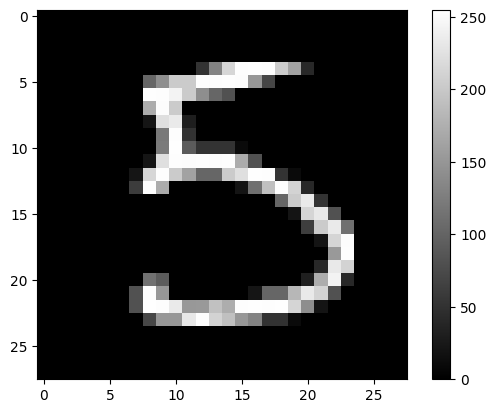

In [61]:
# Serialize the model input
tmp_folder = './tmp/'
index = 15
img_inputs_path = tmp_folder + "inputs/"
os.makedirs(img_inputs_path, exist_ok=True)
x = test_images_tf_downsampled[index]

print(x.dtype, x.shape)
np.save(f"{img_inputs_path}{str(index)}.npy", x)

plt.imshow(test_images[index], cmap='gray')
plt.colorbar()
plt.show()



In [62]:
# Convert the input to the model
input_convert_path = "./tools/input_converter.py"
msgpack_folder = tmp_folder + 'msgpack/'
config_out_path = msgpack_folder+"config.msgpack"
img_in_path = img_inputs_path + str(index)+ ".npy"
img_out_path = msgpack_folder + "img_" + str(index) + ".msgpack"


command = ["python", f"{input_convert_path}", "--model_config", f"{config_out_path}",
           "--inputs", img_in_path, "--output", img_out_path]

subprocess.run(command)


CompletedProcess(args=['python', './tools/input_converter.py', '--model_config', './tmp/msgpack/config.msgpack', '--inputs', './tmp/inputs/15.npy', '--output', './tmp/msgpack/img_15.msgpack'], returncode=0)

In [49]:
test = "./bin/test_circuit"

command = [test, model_out_path, img_out_path]

res = subprocess.run(command, capture_output=True, text=True)
x_values = [int(x) for x in re.findall(r'final out\[\d+\] x: (\d+)', res.stdout)]

# Find max value and its index
max_value = max(x_values)
x_values.index(max_value)


5

In [50]:
test_image = np.expand_dims(test_images_tf_downsampled[index], axis=0)
    
# Set the value for the input tensor
interpreter.set_tensor(input_details[0]['index'], test_image)

# Run the inference
interpreter.invoke()

# Retrieve the output and dequantize
output = interpreter.get_tensor(output_details[0]['index'])
np.argmax(output, axis=1)

array([5])

In [51]:
time_circuit = "./bin/time_circuit"

command= [time_circuit, model_out_path, img_out_path, "kzg"]

subprocess.run(command)


Time elapsed in params construction: 420.317655ms
Processing layer 0, type: FullyConnected, inp_idxes: [0, 3, 2], out_idxes: [5], layer_params: [1]
Out 0 shape: [1, 25]

Processing layer 1, type: FullyConnected, inp_idxes: [5, 4, 1], out_idxes: [6], layer_params: [0]
Out 0 shape: [1, 10]

Processing layer 2, type: Softmax, inp_idxes: [6], out_idxes: [7], layer_params: []
Out 0 shape: [1, 10]

final out[0] x: 0 (0)
final out[1] x: 0 (0)
final out[2] x: 0 (0)
final out[3] x: 0 (0)
final out[4] x: 0 (0)
final out[5] x: 0 (0)
final out[6] x: 0 (0)
final out[7] x: 0 (0)
final out[8] x: 0 (0)
final out[9] x: 0 (0)
final out idxes: [7]
Time elapsed in generating vkey: 1.757827905s
vkey size: 148936 bytes
Processing layer 0, type: FullyConnected, inp_idxes: [0, 3, 2], out_idxes: [5], layer_params: [1]
Out 0 shape: [1, 25]

Processing layer 1, type: FullyConnected, inp_idxes: [5, 4, 1], out_idxes: [6], layer_params: [0]
Out 0 shape: [1, 10]

Processing layer 2, type: Softmax, inp_idxes: [6], ou

CompletedProcess(args=['./bin/time_circuit', './tmp/msgpack/converted_model.msgpack', './tmp/msgpack/img_15.msgpack', 'kzg'], returncode=0)

## Benchmark for 784_56_10

In [19]:
model_path = "../../models/"
arch_folder = "input-dense-dense/"
model_name = "784_56_10.tflite"
model_in_path = model_path+arch_folder+model_name

interpreter = tf.lite.Interpreter(model_path=model_in_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [10]:
predictions_tf = get_predictions(interpreter, test_images_tf)

Quantized model accuracy: 97.40%


### Benchmark

In [20]:
test_size = 1000
loss_, mem_usage_, time_cost_ = benchmark(test_images_tf[:test_size], predictions_tf[:test_size], model_in_path)

Process for image 0


Process for image 1
Process for image 2
Process for image 3
Process for image 4
Process for image 5
Process for image 6
Process for image 7
Process for image 8
Process for image 9
Process for image 10
Process for image 11
Process for image 12
Process for image 13
Process for image 14
Process for image 15
Process for image 16
Process for image 17
Process for image 18
Process for image 19
Process for image 20
Process for image 21
Process for image 22
Process for image 23
Process for image 24
Process for image 25
Process for image 26
Process for image 27
Process for image 28
Process for image 29
Process for image 30
Process for image 31
Process for image 32
Process for image 33
Process for image 34
Process for image 35
Process for image 36
Process for image 37
Process for image 38
Process for image 39
Process for image 40
Process for image 41
Process for image 42
Process for image 43
Process for image 44
Process for image 45
Process for image 46
Process for image 47
Process for image 48
P

In [26]:
new_row = {
    'Framework': ['zkml (tensorflow)'],
    'Architecture': ['Input-Dense-Dense (784x56x10)'],
    '# Layers': [3],
    '# Parameters': [44543],
    'Testing Size': [test_size],
    'Accuracy Loss (%)': [loss_/test_size*100],
    'Avg Memory Usage (MB)': [sum(mem_usage_) / len(mem_usage_)],
    'Std Memory Usage': [pd.Series(mem_usage_).std()],
    'Avg Proving Time (s)': [sum(time_cost_) / len(time_cost_)],
    'Std Proving Time': [pd.Series(time_cost_).std()]
}

new_row_df = pd.DataFrame(new_row)


In [27]:
df = pd.concat([df, new_row_df], ignore_index=True)
df.to_csv(csv_path, index=False)
df

,Framework,Architecture,# Layers,# Parameters,Testing Size,Accuracy Loss (%),Avg Memory Usage (MB),Std Memory Usage,Avg Proving Time (s),Std Proving Time
0,opml (pytorch),Input-Dense-Dense (784 * 56 * 10),3,44543,250,0.40,88.998094,2.285579,3.655122,0.440126
1,opml (pytorch),"Input-Dense-Dense (784 * 56 * 10, w/ relu)",3,44543,1000,20.90,89.122078,2.247846,3.664727,0.433921
2,opml (pytorch),Input-Dense-Dense (784 * 56 * 10),3,44543,2500,0.72,89.120883,2.254392,3.609974,0.421732
3,opml (pytorch),Input-Dense-Dense (196 * 25 * 10,3,5185,5000,3.52,74.351948,1.419725,0.809440,0.074357
4,circomlib-ml (tensorflow),Input-Dense-Dense (196 * 25 * 10,3,5185,2500,0.00,998.735128,8.040170,1.169482,0.108491
5,zkml (tensorflow),Input-Dense-Dense (196 * 25 * 10,3,5185,1000,0.10,2334.295629,12.335301,21.263430,0.294183
6,zkml (tensorflow),Input-Dense-Dense (784 * 56 * 10,3,44543,1000,0.00,2357.363156,11.750076,22.012543,0.317096


## Benchmark for 196_24_14_10

In [28]:
model_path = "../../models/"
arch_folder = "input-dense-dense-dense/"
model_name = "196_24_14_10.tflite"
model_in_path = model_path+arch_folder+model_name

interpreter = tf.lite.Interpreter(model_path=model_in_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [30]:
predictions_tf = get_predictions(interpreter, test_images_tf_downsampled)

Quantized model accuracy: 95.56%


In [33]:
test_size = 2500
loss_, mem_usage_, time_cost_ = benchmark(test_images_tf_downsampled[:test_size], predictions_tf[:test_size], model_in_path)

Process for image 0
Process for image 1
Process for image 2
Process for image 3
Process for image 4
Process for image 5
Process for image 6
Process for image 7
Process for image 8
Process for image 9
Process for image 10
Process for image 11
Process for image 12
Process for image 13
Process for image 14
Process for image 15
Process for image 16
Process for image 17
Process for image 18
Process for image 19
Process for image 20
Process for image 21
Process for image 22
Process for image 23
Process for image 24
Process for image 25
Process for image 26
Process for image 27
Process for image 28
Process for image 29
Process for image 30
Process for image 31
Process for image 32
Process for image 33
Process for image 34
Process for image 35
Process for image 36
Process for image 37
Process for image 38
Process for image 39
Process for image 40
Process for image 41
Process for image 42
Process for image 43
Process for image 44
Process for image 45
Process for image 46
Process for image 47
Pr

In [34]:
new_row = {
    'Framework': ['zkml (tensorflow)'],
    'Architecture': ['Input-Dense-Dense (196x24x14x10'],
    '# Layers': [4],
    '# Parameters': [5228],
    'Testing Size': [test_size],
    'Accuracy Loss (%)': [loss_/test_size*100],
    'Avg Memory Usage (MB)': [sum(mem_usage_) / len(mem_usage_)],
    'Std Memory Usage': [pd.Series(mem_usage_).std()],
    'Avg Proving Time (s)': [sum(time_cost_) / len(time_cost_)],
    'Std Proving Time': [pd.Series(time_cost_).std()]
}

new_row_df = pd.DataFrame(new_row)


In [37]:
df = pd.read_csv(csv_path)
df

,Framework,Architecture,# Layers,# Parameters,Testing Size,Accuracy Loss (%),Avg Memory Usage (MB),Std Memory Usage,Avg Proving Time (s),Std Proving Time
0,opml (pytorch),Input-Dense-Dense (196x25x10),3,5185,5000,3.52,74.351948,1.419725,0.809440,0.074357
1,opml (pytorch),Input-Dense-Dense (784x56x10),3,44543,2500,0.72,89.120883,2.254392,3.609974,0.421732
2,opml (pytorch),Input-Dense-Dense-Dense (196x24x14x10,4,5228,5000,3.42,74.450789,1.491530,0.829767,0.085084
3,circomlib-ml (tensorflow),Input-Dense-Dense (196x25x10),3,5185,2500,0.00,998.735128,8.040170,1.169482,0.108491
4,circomlib-ml (tensorflow),Input-Dense-Dense (784x56x10,3,44543,2500,0.04,2328.322411,34.436486,2.351284,0.147113
5,zkml (tensorflow),Input-Dense-Dense (196x25x10),3,5185,1000,0.10,2334.295629,12.335301,21.263430,0.294183
6,zkml (tensorflow),Input-Dense-Dense (784x56x10),3,44543,1000,0.00,2357.363156,11.750076,22.012543,0.317096
7,zkml (tensorflow),Input-Dense-Dense (196x24x14x10,4,5228,2500,0.00,2338.480847,13.611456,22.168541,0.528263


In [ ]:
df = pd.concat([df, new_row_df], ignore_index=True)
df.to_csv(csv_path, index=False)
df

# CNN

## Prepare

In [9]:
import numpy as np
import torch

# Load TensorFlow MNIST data
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize and reshape
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# Convert to PyTorch format [batch_size, channels, height, width]
train_images_pt = torch.tensor(train_images).permute(0, 3, 1, 2).float()
test_images_pt = torch.tensor(test_images).permute(0, 3, 1, 2).float()

# If additional normalization is required for your PyTorch model, apply it here
# For example, if you use transforms.Normalize((0.1307,), (0.3081,)) in PyTorch, apply similar normalization
mean, std = 0.1307, 0.3081
train_images_pt = (train_images_pt - mean) / std
test_images_pt = (test_images_pt - mean) / std

In [10]:
import numpy as np
import torch

# Load TensorFlow MNIST data
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images_tf = train_images / 255.0
test_images_tf = test_images / 255.0
train_images_tf = train_images_tf.reshape(train_images.shape[0], 28, 28, 1)
test_images_tf = test_images_tf.reshape(test_images.shape[0], 28, 28, 1)

train_images_tf_14 = tf.image.resize(train_images_tf, [14, 14]).numpy()
test_images_tf_14 = tf.image.resize(test_images_tf, [14, 14]).numpy()

2024-02-06 12:27:53.321955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 12:27:53.322670: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 12:27:53.322734: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## For 5_11_80_10 CNN Model with 14x14 input and 3 kernal size

In [21]:
model_path = "../../models/"
arch_folder = "input-conv2d-conv2d-dense-dense/"
layers = [14,5,11,80,10,3]
model_name = "_".join([str(x) for x in layers])+ ".tflite"
model_in_path = model_path+arch_folder+model_name

interpreter = tf.lite.Interpreter(model_path=model_in_path)
interpreter.allocate_tensors()


In [22]:
predictions_tf = get_predictions(interpreter, test_images_tf_14)

Quantized model accuracy: 97.07%


### Test

float32 (14, 14, 1)


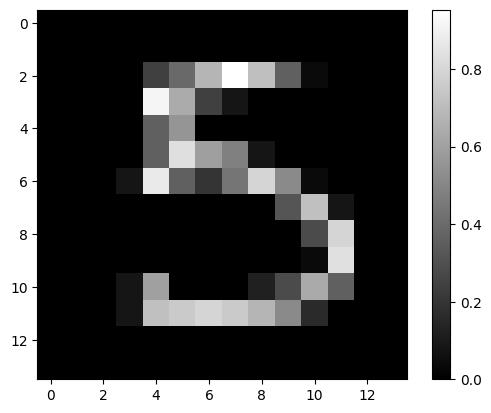

In [23]:
# Serialize the model input
tmp_folder = './tmp/'
index = 15
img_inputs_path = tmp_folder + "inputs/"
os.makedirs(img_inputs_path, exist_ok=True)
x = test_images_tf_14[index]

print(x.dtype, x.shape)
np.save(f"{img_inputs_path}{str(index)}.npy", x)

plt.imshow(test_images_tf_14[index], cmap='gray')
plt.colorbar()
plt.show()

In [24]:
model_convert_path = "./tools/converter.py"
model_out_path = tmp_folder + "msgpack/converted_model.msgpack"
config_path = tmp_folder + "msgpack/config.msgpack"

scale_factor = 512
k = 17
num_cols = 10 
num_randoms = 1024 

command = ["python", model_convert_path, "--model", f"{model_in_path}",
        "--model_output", f"{model_out_path}", "--config_output",
        config_path, "--scale_factor", str(scale_factor),
        "--k", str(k), "--num_cols", str(num_cols), "--num_randoms",
        str(num_randoms)]
subprocess.run(command)

2024-02-06 12:34:57.827390: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 12:34:57.847633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 12:34:57.847651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 12:34:57.848159: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 12:34:57.851256: I tensorflow/core/platform/cpu_feature_guar

2024-02-06 12:34:58.215974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[{'layer_type': 'Conv2D', 'inp_idxes': [0, 3, 1], 'inp_shapes': [[1, 14, 14, 1], [5, 3, 3, 1], [5]], 'out_idxes': [10], 'out_shapes': [[1, 12, 12, 5]], 'params': [0, 1, 1, 1, 1], 'mask': []}, {'layer_type': 'AveragePool2D', 'inp_idxes': [10], 'inp_shapes': [[1, 12, 12, 5]], 'out_idxes': [11], 'out_shapes': [[1, 6, 6, 5]], 'params': [2, 2, 2, 2], 'mask': []}, {'layer_type': 'Conv2D', 'inp_idxes': [11, 4, 2], 'inp_shapes': [[1, 6, 6, 5], [11, 3, 3, 5], [11]], 'out_idxes': [12], 'out_shapes': [[1, 4, 4, 11]], 'params': [0, 1, 1, 1, 1], 'mask': []}, {'layer_type': 'AveragePool2D', 'inp_idxes': [12], 'inp_shapes': [[1, 4, 4, 11]], 'out_idxes': [13], 'out_shapes': [[1, 2, 2, 11]], 'params': [2, 2, 2, 2], 'mask': []}, {'layer_type': 'Reshape', 'inp_idxes': [13, 7], 'inp_shapes': [[1, 2, 2, 11], [2]], 'out_idxes': [14], 'out_shapes': [[1, 44]], 'params': [], 'mask': []}, {'layer_type': 'FullyConnected', 'inp_idxes': [14, 8, 6], 'inp_shapes': [[1, 44], [80, 44], [80]], 'out_idxes': [15], 'out_s

CompletedProcess(args=['python', './tools/converter.py', '--model', '../../models/input-conv2d-conv2d-dense-dense/14_5_11_80_10_3.tflite', '--model_output', './tmp/msgpack/converted_model.msgpack', '--config_output', './tmp/msgpack/config.msgpack', '--scale_factor', '512', '--k', '17', '--num_cols', '10', '--num_randoms', '1024'], returncode=0)

In [25]:
# Convert the input to the model
input_convert_path = "./tools/input_converter.py"
msgpack_folder = tmp_folder + 'msgpack/'
config_out_path = msgpack_folder+"config.msgpack"
img_in_path = img_inputs_path + str(index)+ ".npy"
img_out_path = msgpack_folder + "img_" + str(index) + ".msgpack"


command = ["python", f"{input_convert_path}", "--model_config", f"{config_out_path}",
           "--inputs", img_in_path, "--output", img_out_path]

subprocess.run(command)

CompletedProcess(args=['python', './tools/input_converter.py', '--model_config', './tmp/msgpack/config.msgpack', '--inputs', './tmp/inputs/15.npy', '--output', './tmp/msgpack/img_15.msgpack'], returncode=0)

In [26]:
test = "./bin/test_circuit"

command = [test, model_out_path, img_out_path]


In [27]:
res = subprocess.run(command, capture_output=True, text=True)

x_values = [int(x) for x in re.findall(r'final out\[\d+\] x: (-?\d+) \(', res.stdout)]

# Find max value and its index
max_value = max(x_values)
x_values.index(max_value)


5

### Benchmark

In [29]:
test_size = 1000
loss_, mem_usage_, time_cost_ = benchmark(test_images_tf_14[:test_size], predictions_tf[:test_size], model_in_path)

Process for image 0
Process for image 1
Process for image 2
Process for image 3
Process for image 4
Process for image 5
Process for image 6
Process for image 7
Process for image 8
Process for image 9
Process for image 10
Process for image 11
Process for image 12
Process for image 13
Process for image 14
Process for image 15
Process for image 16
Process for image 17
Process for image 18
Process for image 19
Process for image 20
Process for image 21
Process for image 22
Process for image 23
Process for image 24
Process for image 25
Process for image 26
Process for image 27
Process for image 28
Process for image 29
Process for image 30
Process for image 31
Process for image 32
Process for image 33
Process for image 34
Process for image 35
Process for image 36
Process for image 37
Process for image 38
Process for image 39
Process for image 40
Process for image 41
Process for image 42
Process for image 43
Process for image 44
Process for image 45
Process for image 46
Process for image 47
Pr

In [30]:
new_row = {
    'Framework': ['zkml (tensorflow)'],
    'Architecture': ['Input-Conv2d-Conv2d-Dense-Dense (196x5x11x80x10)'],
    '# Layers': [5],
    '# Parameters': [4996],
    'Testing Size': [test_size],
    'Accuracy Loss (%)': [loss_/test_size*100],
    'Avg Memory Usage (MB)': [sum(mem_usage_) / len(mem_usage_)],
    'Std Memory Usage': [pd.Series(mem_usage_).std()],
    'Avg Proving Time (s)': [sum(time_cost_) / len(time_cost_)],
    'Std Proving Time': [pd.Series(time_cost_).std()],
    'Notes':""
}

new_row_df = pd.DataFrame(new_row)


In [31]:
df = pd.concat([df, new_row_df], ignore_index=True)
df.to_csv(csv_path, index=False)
df

,Framework,Architecture,# Layers,# Parameters,Testing Size,Accuracy Loss (%),Avg Memory Usage (MB),Std Memory Usage,Avg Proving Time (s),Std Proving Time,Notes,Notes
0,opml (pytorch),Input-Dense-Dense (196x25x10),3,5185,5000.0,3.52,74.3519484375,1.419725,0.809440,0.074357,NaN,NaN
1,opml (pytorch),Input-Dense-Dense-Dense (196x24x14x10),4,5228,5000.0,3.42,74.4507890625,1.491530,0.829767,0.085084,NaN,NaN
2,opml (pytorch),Input-Dense-Dense (784x56x10),3,44543,2500.0,0.72,89.1208828125,2.254392,3.609974,0.421732,NaN,NaN
3,circomlib-ml (tensorflow),Input-Dense-Dense (196x25x10),3,5185,2500.0,0.00,998.735128125,8.040170,1.169482,0.108491,non-linear constraints: 18075,NaN
4,circomlib-ml (tensorflow),Input-Dense-Dense-Dense (196x24x14x10),4,5228,2500.0,0.88,315.435559375,1.690681,0.452942,0.031613,non-linear constraints: 24826,NaN
5,circomlib-ml (tensorflow),Input-Dense-Dense (784x56x10),3,44543,2500.0,0.04,2328.3224109375,34.436486,2.351284,0.147113,non-linear constraints: 73416,NaN
6,circomlib-ml (tensorflow),Input-Conv2d-Conv2d-Dense (784x6x16x10),4,5142,NaN,NaN,.,NaN,NaN,NaN,non-linear constraints: 2558720,NaN
7,zkml (tensorflow),Input-Dense-Dense (196x25x10),3,5185,1000.0,0.10,2334.29562890625,12.335301,21.263430,0.294183,NaN,NaN
8,zkml (tensorflow),Input-Dense-Dense-Dense (196x24x14x10),4,5228,2500.0,0.00,2338.480846875,13.611456,22.168541,0.528263,NaN,NaN
9,zkml (tensorflow),Input-Dense-Dense (784x56x10),3,44543,1000.0,0.00,2357.36315625,11.750076,22.012543,0.317096,NaN,NaN


### Benchmark for 784_6_16_120_84_10 CNN Model

In [ ]:
model_path = "../../models/"
arch_folder = "input-conv2d-conv2d-dense-dense-dense/"
model_name = "784_6_16_120_84_10.tflite"
model_in_path = model_path+arch_folder+model_name

interpreter = tf.lite.Interpreter(model_path=model_in_path)
interpreter.allocate_tensors()

In [ ]:
predictions_tf = get_predictions(interpreter, test_images)

Quantized model accuracy: 98.66%


In [ ]:
test_size = 3
benchmark(test_images_tf[:test_size], predictions_tf[:test_size], model_in_path)

Process for image 0
Process for image 1
Process for image 2
Total time: 53.79765033721924


(0,
 [1794.25, 1798.62890625, 1790.05859375],
 [18.402644395828247, 17.688000679016113, 17.7068350315094])

## For 784_6_16_10 CNN Model

In [12]:
model_path = "../../models/"
arch_folder = "input-conv2d-conv2d-dense/"
model_name = "784_6_16_10.tflite"
model_in_path = model_path+arch_folder+model_name

interpreter = tf.lite.Interpreter(model_path=model_in_path)
interpreter.allocate_tensors()


In [13]:
predictions_tf = get_predictions(interpreter, test_images)

Quantized model accuracy: 98.66%


### Test

float64 (28, 28, 1)


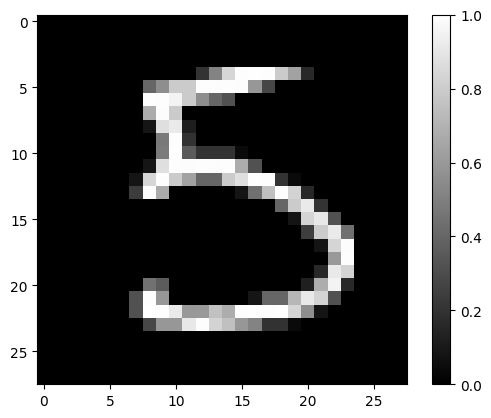

In [23]:
# Serialize the model input
tmp_folder = './tmp/'
index = 15
img_inputs_path = tmp_folder + "inputs/"
os.makedirs(img_inputs_path, exist_ok=True)
x = test_images[index]

print(x.dtype, x.shape)
np.save(f"{img_inputs_path}{str(index)}.npy", x)

plt.imshow(test_images[index], cmap='gray')
plt.colorbar()
plt.show()

In [24]:
model_convert_path = "./tools/converter.py"
model_out_path = tmp_folder + "msgpack/converted_model.msgpack"
config_path = tmp_folder + "msgpack/config.msgpack"

scale_factor = 512
k = 17
num_cols = 10 
num_randoms = 1024 

command = ["python", model_convert_path, "--model", f"{model_in_path}",
        "--model_output", f"{model_out_path}", "--config_output",
        config_path, "--scale_factor", str(scale_factor),
        "--k", str(k), "--num_cols", str(num_cols), "--num_randoms",
        str(num_randoms)]
subprocess.run(command)

2024-02-05 14:09:50.054910: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 14:09:50.086956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 14:09:50.086983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 14:09:50.087690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 14:09:50.091992: I tensorflow/core/platform/cpu_feature_guar

[{'layer_type': 'Conv2D', 'inp_idxes': [0, 3, 1], 'inp_shapes': [[1, 28, 28, 1], [6, 5, 5, 1], [6]], 'out_idxes': [8], 'out_shapes': [[1, 24, 24, 6]], 'params': [0, 1, 1, 1, 1], 'mask': []}, {'layer_type': 'AveragePool2D', 'inp_idxes': [8], 'inp_shapes': [[1, 24, 24, 6]], 'out_idxes': [9], 'out_shapes': [[1, 12, 12, 6]], 'params': [2, 2, 2, 2], 'mask': []}, {'layer_type': 'Conv2D', 'inp_idxes': [9, 4, 2], 'inp_shapes': [[1, 12, 12, 6], [16, 5, 5, 6], [16]], 'out_idxes': [10], 'out_shapes': [[1, 8, 8, 16]], 'params': [0, 1, 1, 1, 1], 'mask': []}, {'layer_type': 'AveragePool2D', 'inp_idxes': [10], 'inp_shapes': [[1, 8, 8, 16]], 'out_idxes': [11], 'out_shapes': [[1, 4, 4, 16]], 'params': [2, 2, 2, 2], 'mask': []}, {'layer_type': 'Reshape', 'inp_idxes': [11, 6], 'inp_shapes': [[1, 4, 4, 16], [2]], 'out_idxes': [12], 'out_shapes': [[1, 256]], 'params': [], 'mask': []}, {'layer_type': 'FullyConnected', 'inp_idxes': [12, 7, 5], 'inp_shapes': [[1, 256], [10, 256], [10]], 'out_idxes': [13], 'ou

CompletedProcess(args=['python', './tools/converter.py', '--model', '../../models/input-conv2d-conv2d-dense/784_6_16_10.tflite', '--model_output', './tmp/msgpack/converted_model.msgpack', '--config_output', './tmp/msgpack/config.msgpack', '--scale_factor', '512', '--k', '17', '--num_cols', '10', '--num_randoms', '1024'], returncode=0)

In [25]:
# Convert the input to the model
input_convert_path = "./tools/input_converter.py"
msgpack_folder = tmp_folder + 'msgpack/'
config_out_path = msgpack_folder+"config.msgpack"
img_in_path = img_inputs_path + str(index)+ ".npy"
img_out_path = msgpack_folder + "img_" + str(index) + ".msgpack"


command = ["python", f"{input_convert_path}", "--model_config", f"{config_out_path}",
           "--inputs", img_in_path, "--output", img_out_path]

subprocess.run(command)

CompletedProcess(args=['python', './tools/input_converter.py', '--model_config', './tmp/msgpack/config.msgpack', '--inputs', './tmp/inputs/15.npy', '--output', './tmp/msgpack/img_15.msgpack'], returncode=0)

In [ ]:
test = "./bin/test_circuit"

command = [test, model_out_path, img_out_path]


In [32]:
res = subprocess.run(command, capture_output=True, text=True)

x_values = [int(x) for x in re.findall(r'final out\[\d+\] x: (-?\d+) \(', res.stdout)]

# Find max value and its index
max_value = max(x_values)
x_values.index(max_value)


5

### Benchmark

In [16]:
test_size = 1000
loss_, mem_usage_, time_cost_ = benchmark(test_images[:test_size], predictions_tf[:test_size], model_in_path)

Process for image 0
Process for image 1
Process for image 2
Process for image 3
Process for image 4
Process for image 5
Process for image 6
Process for image 7
Process for image 8
Process for image 9
Process for image 10
Process for image 11
Process for image 12
Process for image 13
Process for image 14
Process for image 15
Process for image 16
Process for image 17
Process for image 18
Process for image 19
Process for image 20
Process for image 21
Process for image 22
Process for image 23
Process for image 24
Process for image 25
Process for image 26
Process for image 27
Process for image 28
Process for image 29
Process for image 30
Process for image 31
Process for image 32
Process for image 33
Process for image 34
Process for image 35
Process for image 36
Process for image 37
Process for image 38
Process for image 39
Process for image 40
Process for image 41
Process for image 42
Process for image 43
Process for image 44
Process for image 45
Process for image 46
Process for image 47
Pr

(1,
 [1762.15625,
  1769.8359375,
  1773.59375,
  1767.7734375,
  1774.0703125,
  1774.23828125,
  1753.8046875,
  1762.0078125,
  1774.14453125,
  1758.265625,
  1773.91796875,
  1758.28125,
  1761.56640625,
  1778.1171875,
  1771.875,
  1765.8203125,
  1761.3046875,
  1765.73046875,
  1785.99609375,
  1757.80078125,
  1773.53125,
  1786.1328125,
  1766.03515625,
  1773.92578125,
  1773.83203125,
  1749.640625,
  1758.14453125,
  1765.8984375,
  1773.9453125,
  1766.40625,
  1757.75390625,
  1757.94921875,
  1757.85546875,
  1765.91015625,
  1761.4453125,
  1765.60546875,
  1766.25390625,
  1761.8125,
  1776.85546875,
  1769.80078125,
  1769.890625,
  1758.12109375,
  1789.8828125,
  1761.984375,
  1755.79296875,
  1777.83984375,
  1757.84765625,
  1758.12890625,
  1766.1953125,
  1761.8515625,
  1762.34375,
  1754.09375,
  1760.00390625,
  1773.9921875,
  1770.41015625,
  1753.68359375,
  1765.4921875,
  1747.234375,
  1762.03125,
  1753.81640625,
  1761.58984375,
  1769.86328125,
  

In [22]:
new_row = {
    'Framework': ['zkml (tensorflow)'],
    'Architecture': ['Input-Conv2d-Conv2d-Dense (784x6x16x10)'],
    '# Layers': [4],
    '# Parameters': [5142],
    'Testing Size': [test_size],
    'Accuracy Loss (%)': [loss_/test_size*100],
    'Avg Memory Usage (MB)': [sum(mem_usage_) / len(mem_usage_)],
    'Std Memory Usage': [pd.Series(mem_usage_).std()],
    'Avg Proving Time (s)': [sum(time_cost_) / len(time_cost_)],
    'Std Proving Time': [pd.Series(time_cost_).std()]
}

new_row_df = pd.DataFrame(new_row)


In [23]:
df = pd.concat([df, new_row_df], ignore_index=True)
df.to_csv(csv_path, index=False)
df

,Framework,Architecture,# Layers,# Parameters,Testing Size,Accuracy Loss (%),Avg Memory Usage (MB),Std Memory Usage,Avg Proving Time (s),Std Proving Time
0,opml (pytorch),Input-Dense-Dense (196x25x10),3,5185,5000,3.52,74.351948,1.419725,0.809440,0.074357
1,opml (pytorch),Input-Dense-Dense-Dense (196x24x14x10),4,5228,5000,3.42,74.450789,1.491530,0.829767,0.085084
2,opml (pytorch),Input-Dense-Dense (784x56x10),3,44543,2500,0.72,89.120883,2.254392,3.609974,0.421732
3,circomlib-ml (tensorflow),Input-Dense-Dense (196x25x10),3,5185,2500,0.00,998.735128,8.040170,1.169482,0.108491
4,circomlib-ml (tensorflow),Input-Dense-Dense-Dense (196x24x14x10),4,5228,2500,0.88,315.435559,1.690681,0.452942,0.031613
5,circomlib-ml (tensorflow),Input-Dense-Dense (784x56x10),3,44543,2500,0.04,2328.322411,34.436486,2.351284,0.147113
6,zkml (tensorflow),Input-Dense-Dense (196x25x10),3,5185,1000,0.10,2334.295629,12.335301,21.263430,0.294183
7,zkml (tensorflow),Input-Dense-Dense-Dense (196x24x14x10),4,5228,2500,0.00,2338.480847,13.611456,22.168541,0.528263
8,zkml (tensorflow),Input-Dense-Dense (784x56x10),3,44543,1000,0.00,2357.363156,11.750076,22.012543,0.317096
9,ezkl (pytorch),Input-Dense-Dense (196x25x10),3,5185,10000,4.11,91.608069,0.756873,0.660479,0.025701


### Benchmark for 784_6_16_120_84_10 CNN Model

In [36]:
model_path = "../../models/"
arch_folder = "input-conv2d-conv2d-dense-dense-dense/"
model_name = "784_6_16_120_84_10.tflite"
model_in_path = model_path+arch_folder+model_name

interpreter = tf.lite.Interpreter(model_path=model_in_path)
interpreter.allocate_tensors()

In [37]:
predictions_tf = get_predictions(interpreter, test_images)

Quantized model accuracy: 98.66%


In [38]:
test_size = 3
benchmark(test_images_tf[:test_size], predictions_tf[:test_size], model_in_path)

Process for image 0
Process for image 1
Process for image 2
Total time: 53.79765033721924


(0,
 [1794.25, 1798.62890625, 1790.05859375],
 [18.402644395828247, 17.688000679016113, 17.7068350315094])